### Set-up libraries for text analysis and Twitter connection for getting tweets

In [1]:
# Import libraries
import numpy as np
import string
import matplotlib.pyplot as plt
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Imports of text mining libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.probability import FreqDist, ConditionalFreqDist
from collections import Counter
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

# Import twitter api library
!pip install tweepy
import tweepy        # https://github.com/tweepy/tweepy
import json

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  Using cached tweepy-4.1.0-py2.py3-none-any.whl (62 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)


In [3]:
# Setup the Twitter connection (keys and secrets)
# Add Twitter keys and secrets 
access_key = '--------'
access_secret = '--------'
api_key = '--------'
api_secret = '--------'

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

# Test the connection
#public_tweets = api.home_timeline()
#pp.pprint(public_tweets[0].text)

### Set-up functions for preprocessing data and visualisations

In [14]:
# Function for creating a wordcloud
def make_wordcloud(word_dict, title='Wordcloud.png'):
    # make a wordcloud
    fig = plt.figure(figsize = (8, 6))
    cloud = WordCloud(width=800, height=400, max_font_size=160, 
                  colormap="viridis", 
                  background_color='white',).generate_from_frequencies(word_dict)
    
    cloud.to_file(title)
    plt.figure(figsize=(10,6))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Function for creating a frequency distribution graph    
def plot_freqdistribution(word_list, most_common_count=30, 
                          freq_title='Frequency distribution of 30 most common words', show='n'):
    # make a frequency distribution graph
    fdist = FreqDist(word_list)
    if show == 'y':
        print(fdist.most_common(most_common_count))
    fdist.plot(most_common_count, title=freq_title)

# Function for preprocessing text (tokenize and lowercase)
def gettokens(text):
    # Tokenize
    string = " ".join(text)
    tokens = word_tokenize(string)
    tokens_lower = [token.lower() for token in tokens]
    return tokens_lower
    
# Clean up - remove stopwords, punctuation and conflicting words
additional_toremove = ['https', 'rt', '``', '...', '…', "''", '’', '“', '”', "'s", "-", "‘", "–", "n't", "f", 
                      "nigella_i5e", "'re", "//t.co/2np…", "a…", "amp", "//t.co/cismanhpqk", '—', 'l…',
                      '//t.co/lzffsptn6n', 'fr…']
additional_toremove_ca = ['climatechange', 'climatecrisis', 'climateaction', 'climateemergency',
                         'actonclimate', 'climatechangeisreal', 'sustainability']
additional_toremove_cd = ['climatehoax', 'climatechangefraud', 'climatechangescam',
                          'climatescam', 'climatefraud', 'climatecult', 'globalwarmingscam', 
                          'globalwarmingfraud', 'globalwarminghoax', 'climaterealists',
                         'tony_yors']
remove_these_ca = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) 
                      + additional_toremove + additional_toremove_ca)
remove_these_cd = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) 
                      + additional_toremove + additional_toremove_cd)

# Fuction for getting entities of a specific type
def get_entities_of_type(type_we_seek, entities):
    ents = [string for (string, tag) in entities if (tag == type_we_seek)] 
    print("Number of strings tagged as " + type_we_seek + " " + str(len(ents)))
    return ents

# Lists for POS tags
posnouns = ['NN', 'NNS', 'NNP', 'NNPS']
posverbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
posadverbs = ['RB', 'RBR', 'RBS']

### Gather Twitter Data - split in two groups: climate action and climate denier tweets

In [5]:
# Get some pages of climate action tweets based on the hashtags used
# list based on: https://awario.com/blog/climate-change-denial/
climateaction_tweets = []
for page in tweepy.Cursor(api.search_tweets,
                         q='#climatechange OR #climatecrisis OR #climateaction \
                         OR #climateemergency OR #climatechangeisreal \
                         OR #sustainability OR #actonclimate',
                         lang='en', count=50).pages(20):
    climateaction_tweets.append(page)
    
print('Finished getting tweets')
# pp.pprint(climateaction_tweets[0][0]._json)

# Count how many climate action tweets we got
ca_tweetcount = 0
for page in np.arange(len(climateaction_tweets)):
    ca_tweetcount += len(climateaction_tweets[page])

print('Climate action tweets: ', ca_tweetcount)

Finished getting tweets
Climate action tweets:  1000


In [6]:
# Get some pages of climate change denier tweets based on the hashtags used
# list based on: https://awario.com/blog/climate-change-denial/
climatedeny_tweets = []
for page in tweepy.Cursor(api.search_tweets,
                         q='#climatehoax OR #climatechangefraud OR #climatechangescam \
                         OR #climatescam OR #climatefraud OR #climatecult \
                         OR #globalwarmingscam OR #globalwarmingfraud OR #globalwarminghoax \
                         OR #climaterealists',
                         lang='en', count=100).pages(20):
    climatedeny_tweets.append(page)
    
print('Finished getting tweets')
# pp.pprint(climatedeny_tweets[0][0]._json)

# Count how many climate deny tweets we got
cd_tweetcount = 0
for page in np.arange(len(climatedeny_tweets)):
    cd_tweetcount += len(climatedeny_tweets[page])
    
print('Climate deny tweets: ', cd_tweetcount)

Finished getting tweets
Climate deny tweets:  1222


### Getting text and preprocessing for analysis

In [7]:
# Get the text from those tweets
climateaction_text = []
for page in np.arange(len(climateaction_tweets)):
    for each in climateaction_tweets[page]:
        climateaction_text.append(each._json['text'])
        
climatedeny_text = []
for page in np.arange(len(climatedeny_tweets)):
    for each in climatedeny_tweets[page]:
        climatedeny_text.append(each._json['text'])

In [15]:
# Tokenize
climateaction_tokens = gettokens(climateaction_text)
climatedeny_tokens = gettokens(climatedeny_text)

# Clean-up
climateaction_filtered = [token
                 for token in climateaction_tokens
                 if not token in remove_these_ca]
climatedeny_filtered = [token
                       for token in climatedeny_tokens
                       if not token in remove_these_cd]

#print(proclimate_filtered[:20])

In [16]:
# POS tagging
tagged_climateaction_tokens = nltk.pos_tag(climateaction_filtered)
tagged_climatedeny_tokens = nltk.pos_tag(climatedeny_filtered)

climateaction_nouns = [word for (word, pos) in tagged_climateaction_tokens
                      if (pos in posnouns)]
climatedeny_nouns = [word for (word, pos) in tagged_climatedeny_tokens
                      if (pos in posnouns)]
climateaction_verbs = [word for (word, pos) in tagged_climateaction_tokens
                      if (pos in posverbs)]
climatedeny_verbs = [word for (word, pos) in tagged_climatedeny_tokens
                      if (pos in posverbs)]
climateaction_adverbs = [word for (word, pos) in tagged_climateaction_tokens
                      if (pos in posadverbs)]
climatedeny_adverbs = [word for (word, pos) in tagged_climatedeny_tokens
                      if (pos in posadverbs)]

### Text analysis - word frequency distribution

In [40]:
# Frequency distribution of language used in climate action tweets
climateaction_fdist = FreqDist(climateaction_filtered)
# Frequency distribution of language used in climate deny tweets
climatedeny_fdist = FreqDist(climatedeny_filtered)

In [41]:
# Looking at the 25 most common words, find which are common between 
# the climate action tweets and climate deny tweets
most_common = 25

ca_mostcommonwords = []
for word, count in climateaction_fdist.most_common(most_common):
    ca_mostcommonwords.append(word)
    
cd_mostcommonwords = []
for word, count in climatedeny_fdist.most_common(most_common):
    cd_mostcommonwords.append(word)

cacd_common = list(set(ca_mostcommonwords).intersection(cd_mostcommonwords))
print('Common words in climate action and climate sceptic tweets: ', cacd_common)

Common words in climate action and climate sceptic tweets:  ['climate', 'get', 'hear', 'change']


<ipython-input-54-386c9c33085a>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=ca_words, rotation=90)
<ipython-input-54-386c9c33085a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=cd_words, rotation=90)


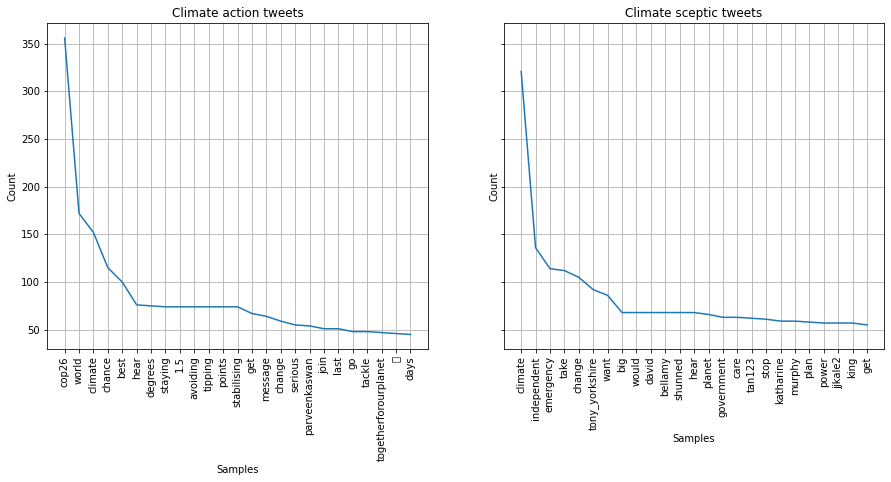

In [54]:
# Get the frequency of words in each group of tweets
ca_words = []
ca_values= []
for word, count in climateaction_fdist.most_common(most_common):
    ca_words.append(word)
    ca_values.append(count)

cd_words = []
cd_values = []
for word, count in climatedeny_fdist.most_common(most_common):
    cd_words.append(word)
    cd_values.append(count)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15, 6), sharey=True)

# Plot the frequency distribution for the climate action tweets
ax[0].plot(ca_words, ca_values, '-')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(labels=ca_words, rotation=90)
ax[0].set_title('Climate action tweets', fontsize=12)
ax[0].grid(which='major')

# Plot the frequency distribution for the climate sceptic tweets
ax[1].plot(cd_words, cd_values, '-')
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Count')
ax[1].set_xticklabels(labels=cd_words, rotation=90)
ax[1].set_title('Climate sceptic tweets', fontsize=12)
ax[1].grid(which='major')

plt.savefig('freqdist_cacd', format='png', bbox_inches="tight")
plt.show()

In [44]:
# Print the most common climate action words with count over 50
mostcommon_ca = climateaction_fdist.most_common(most_common)
print('Most common climate action words: ', mostcommon_ca)

for word, count in mostcommon_ca:
    if count >= 50:
        print(word, count)

Most common climate action words:  [('cop26', 356), ('world', 172), ('climate', 152), ('chance', 115), ('best', 100), ('hear', 76), ('degrees', 75), ('staying', 74), ('1.5', 74), ('avoiding', 74), ('tipping', 74), ('points', 74), ('stabilising', 74), ('get', 67), ('message', 64), ('change', 59), ('serious', 55), ('parveenkaswan', 54), ('join', 51), ('last', 51), ('go', 48), ('tackle', 48), ('togetherforourplanet', 47), ('🌍', 46), ('days', 45)]
cop26 356
world 172
climate 152
chance 115
best 100
hear 76
degrees 75
staying 74
1.5 74
avoiding 74
tipping 74
points 74
stabilising 74
get 67
message 64
change 59
serious 55
parveenkaswan 54
join 51
last 51


In [45]:
# Print the most common climate sceptic words with count over 50
mostcommon_cd = climatedeny_fdist.most_common(most_common)
print('Most common climate deny words: ', mostcommon_cd)

for word, count in mostcommon_cd:
    if count >= 50:
        print(word, count)

Most common climate deny words:  [('climate', 321), ('independent', 136), ('emergency', 114), ('take', 112), ('change', 105), ('tony_yorkshire', 92), ('want', 86), ('big', 68), ('would', 68), ('david', 68), ('bellamy', 68), ('shunned', 68), ('hear', 68), ('planet', 66), ('government', 63), ('care', 63), ('tan123', 62), ('stop', 61), ('katharine', 59), ('murphy', 59), ('plan', 58), ('power', 57), ('jjkale2', 57), ('king', 57), ('get', 55)]
climate 321
independent 136
emergency 114
take 112
change 105
tony_yorkshire 92
want 86
big 68
would 68
david 68
bellamy 68
shunned 68
hear 68
planet 66
government 63
care 63
tan123 62
stop 61
katharine 59
murphy 59
plan 58
power 57
jjkale2 57
king 57
get 55


In [73]:
# Visualise with a wordcloud the most common words used in climate action tweets
#climateaction_dict = Counter(climateaction_filtered)
#make_wordcloud(climateaction_dict, title='wordcloud_ca.png')

In [74]:
# Visualise with a wordcloud the most common words used in climate deny tweets
#climatedeny_dict = Counter(climatedeny_filtered)
#make_wordcloud(climatedeny_dict, title='wordcloud_cd.png')

### Text analysis - frequency of #cop26

In [22]:
# Search for mention of cop26 hashtags in each group of tweets
ca_htags = []
ca_cop26_htags = []
for search_result in climateaction_tweets:
    for status in search_result:  # for every tweet
        hashtags = status.entities['hashtags']
        if len(hashtags) > 0:     # if there are hashtags
            for h in hashtags:
                ca_htags.append(h['text'])
                if re.search('^[cC][oO][pP]26.*$', h['text']):
                    ca_cop26_htags.append(h['text'])

cd_htags = []
cd_cop26_htags = []
for search_result in climatedeny_tweets:
    for status in search_result:  # for every tweet
        hashtags = status.entities['hashtags']
        if len(hashtags) > 0:     # if there are hashtags
            for h in hashtags:
                cd_htags.append(h['text'])
                if re.search('^[cC][oO][pP]26.*$', h['text']):
                    cd_cop26_htags.append(h['text'])

print('Number of times #cop26 hashtags appear in climate action tweets', len(ca_cop26_htags))
print('Number of times #cop26 hashtags appear in climate deny tweets', len(cd_cop26_htags))

Number of times #cop26 hashtags appear in climate action tweets 214
Number of times #cop26 hashtags appear in climate deny tweets 61


### Wordclouds of most common hashtags

<Figure size 576x432 with 0 Axes>

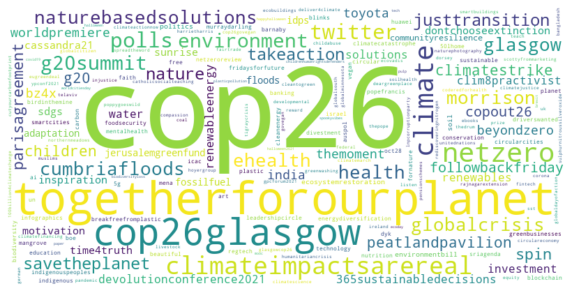

In [25]:
# Visualise with a wordcloud the most common hashtags used in climate action tweets
ca_htags_tokens = gettokens(ca_htags)
ca_htags_filtered = [token
                 for token in ca_htags_tokens
                 if not token in remove_these_ca]

simplefreq_ca_htags = Counter(ca_htags_filtered)
make_wordcloud(simplefreq_ca_htags, title='wordcloud_ca_htags_filtered.png')

<Figure size 576x432 with 0 Axes>

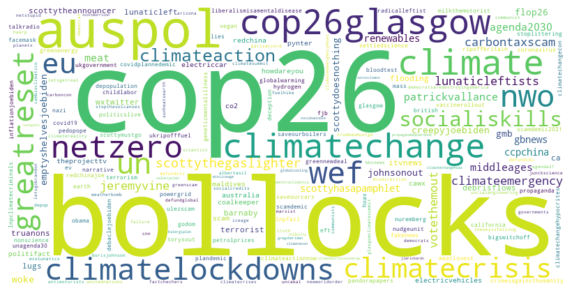

In [27]:
# Visualise with a wordcloud the most common hashtags used in climate sceptic tweets
cd_htags_tokens = gettokens(cd_htags)
cd_htags_filtered = [token
                 for token in cd_htags_tokens
                 if not token in remove_these_cd]

simplefreq_cd_htags = Counter(cd_htags_filtered)
make_wordcloud(simplefreq_cd_htags, title='wordcloud_cd_htags_filtered.png')

### Sentiment analysis - check the polarity score for each group of tweets 

In [38]:
# Do a simple sentiment analysis on the climate action tweets and the climate deny tweets
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
# Get the polarity score for each climate action tweet
climateaction_scores = []
for page in np.arange(len(climateaction_tweets)):
    for each in climateaction_tweets[page]:
        tweet = each._json['text']
        score = sia.polarity_scores(tweet)['compound']
        climateaction_scores.append(score)

# Get the polarity score for each climate deny tweet
climatedeny_scores = []
for page in np.arange(len(climatedeny_tweets)):
    for each in climatedeny_tweets[page]:
        tweet = each._json['text']
        score = sia.polarity_scores(tweet)['compound']
        climatedeny_scores.append(score)

# Get the average score of climate action and climate deny tweets
climateaction_scores = np.array(climateaction_scores)
climatedeny_scores = np.array(climatedeny_scores)
print('Average polarity score for climate action tweets: {:3f}'.format(climateaction_scores.mean()))
print('Average polarity score for climate deny tweets: {:3f}'.format(climatedeny_scores.mean()))

Average polarity score for climate action tweets: 0.174056
Average polarity score for climate deny tweets: -0.045096
